# FNC 8.4 — Exercises 2, 5, 7(c) (Python Notebook)

This notebook answers the **programming** exercises from **FNC 8.4 — Krylov subspaces**.

- Written exercises **1, 3, 4, 6, 7(a), 7(b)** are answered in `习题解答/na_sol_datahub_8/main.tex`.

We implement the Krylov-matrix builder and **Function 8.4.7** (`arnoldi`).


In [1]:
# If you're running locally and miss a dependency, uncomment the next line.
# %pip install --index-url https://pypi.org/simple numpy scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse


## Helpers: density, Krylov matrix, Arnoldi (Function 8.4.7)

In [2]:
def density(A) -> float:
    if sparse.issparse(A):
        return float(A.nnz) / (A.shape[0] * A.shape[1])
    A = np.asarray(A)
    return float(np.count_nonzero(A)) / A.size


def krylov_matrix(A, u, m: int, *, renormalize: bool = True) -> np.ndarray:
    '''Build K_m = [u, Au, ..., A^{m-1}u].

    Following Demo 8.4.3, we optionally renormalize after each matvec to avoid
    overflow/underflow; this keeps the basis usable for numerical experiments.
    '''
    u = np.asarray(u, dtype=float).reshape(-1)
    n = u.size
    K = np.zeros((n, m), dtype=float)
    v = u.copy()
    for j in range(m):
        K[:, j] = v
        v = A @ v if not sparse.issparse(A) else A.dot(v)
        if renormalize:
            nv = np.linalg.norm(v)
            if nv == 0:
                break
            v = v / nv
    return K


def cond2_rect(K: np.ndarray) -> float:
    '''2-norm condition number for a (possibly rectangular) matrix.'''
    s = np.linalg.svd(K, compute_uv=False)
    smax = float(s[0])
    smin = float(s[-1])
    if smin == 0:
        return np.inf
    return smax / smin


def arnoldi(A, u, m: int):
    '''Function 8.4.7 (Arnoldi).

    Returns Q (n×(m+1)) and H ((m+1)×m). Raises on exact breakdown.
    '''
    u = np.asarray(u, dtype=float).reshape(-1)
    n = u.size

    Q = np.zeros((n, m + 1), dtype=float)
    H = np.zeros((m + 1, m), dtype=float)

    Q[:, 0] = u / np.linalg.norm(u)

    for j in range(m):
        v = A @ Q[:, j] if not sparse.issparse(A) else A.dot(Q[:, j])
        for i in range(j + 1):
            H[i, j] = float(np.dot(Q[:, i], v))
            v = v - H[i, j] * Q[:, i]
        H[j + 1, j] = float(np.linalg.norm(v))
        if H[j + 1, j] == 0:
            raise ZeroDivisionError(
                f"Arnoldi breakdown at step j={j+1}: ||v||=0 (Krylov space stops growing)."
            )
        Q[:, j + 1] = v / H[j + 1, j]

    return Q, H


## Exercise 2 — Condition numbers of Krylov matrices

For each matrix, make a table of the 2-norm condition numbers κ(Kₘ) for m=1,…,10.
We use a seed vector of all ones, and (as in Demo 8.4.3) renormalize after each matvec.


In [3]:
def tri_toeplitz(n: int, *, periodic: bool = False) -> sparse.csc_matrix:
    main = -2.0 * np.ones(n)
    off = 1.0 * np.ones(n - 1)
    A = sparse.diags([off, main, off], offsets=[-1, 0, 1], format='csc')
    if periodic:
        A = A + sparse.csc_matrix(([1.0, 1.0], ([0, n - 1], [n - 1, 0])), shape=(n, n))
    return A


rng = np.random.default_rng(123)

# (a) Demo 8.4.3 matrix
n = 100
lam = 10.0 + np.arange(1, n + 1)  # 11..110
A_demo = np.triu(rng.random((n, n)), 1) + np.diag(lam)

# (b) 100×100 tridiagonal
A_tri_100 = tri_toeplitz(100, periodic=False)

# (c) 200×200 with periodic wrap
A_tri_200 = tri_toeplitz(200, periodic=True)

m_values = range(1, 11)
seed_ones_100 = np.ones(100)
seed_ones_200 = np.ones(200)

cases = [
    ('(a) Demo 8.4.3 (100×100 upper-triangular)', A_demo, seed_ones_100),
    ('(b) 100×100 tridiagonal', A_tri_100, seed_ones_100),
    ('(c) 200×200 periodic tridiagonal', A_tri_200, seed_ones_200),
]

for title, A, u in cases:
    print()
    print(title)
    print('m   cond2(Km)')
    for m in m_values:
        K = krylov_matrix(A, u, m, renormalize=True)
        kappa = cond2_rect(K)
        print(f'{m:2d}  {kappa: .6e}')



(a) Demo 8.4.3 (100×100 upper-triangular)
m   cond2(Km)
 1   1.000000e+00
 2   5.926439e+01
 3   5.132422e+02
 4   3.595991e+03
 5   2.173335e+04
 6   1.434606e+05
 7   9.085644e+05
 8   5.671468e+06
 9   3.928955e+07
10   2.450350e+08

(b) 100×100 tridiagonal
m   cond2(Km)
 1   1.000000e+00
 2   1.010357e+01
 3   3.124196e+01
 4   1.185928e+02
 5   5.126147e+02
 6   2.376250e+03
 7   1.150098e+04
 8   5.732473e+04
 9   2.918913e+05
10   1.510590e+06

(c) 200×200 periodic tridiagonal
m   cond2(Km)
 1   1.000000e+00
 2   inf
 3   inf
 4   inf
 5   inf
 6   inf
 7   inf
 8   inf
 9   inf
10   inf


## Exercise 5 — Arnoldi dependence on the seed vector

We apply Function 8.4.7 to

\[A = \begin{bmatrix}2&1&1&0\\ 1&3&1&0\\ 0&1&3&1\\ 0&1&1&2\end{bmatrix}\]

with m=3 (so Q is 4×4 and H is 4×3).


In [4]:
A = np.array(
    [
        [2.0, 1.0, 1.0, 0.0],
        [1.0, 3.0, 1.0, 0.0],
        [0.0, 1.0, 3.0, 1.0],
        [0.0, 1.0, 1.0, 2.0],
    ]
)

seed_vectors = {
    '(i) u=e1': np.array([1.0, 0.0, 0.0, 0.0]),
    '(ii) u=ones': np.ones(4),
    '(iii) u=rand(4)': np.random.default_rng(0).standard_normal(4),
}

for name, u in seed_vectors.items():
    print()
    print(name)
    try:
        Q, H = arnoldi(A, u, m=3)
        print('Q=')
        print(np.array_str(Q, precision=6, suppress_small=True))
        print('H=')
        print(np.array_str(H, precision=6, suppress_small=True))
    except ZeroDivisionError as e:
        print('Arnoldi failed:', e)



(i) u=e1
Q=
[[ 1.        0.        0.        0.      ]
 [ 0.        1.        0.        0.      ]
 [ 0.        0.        0.707107  0.707107]
 [ 0.        0.        0.707107 -0.707107]]
H=
[[2.       1.       0.707107]
 [1.       3.       0.707107]
 [0.       1.414214 3.5     ]
 [0.       0.       0.5     ]]

(ii) u=ones
Arnoldi failed: Arnoldi breakdown at step j=2: ||v||=0 (Krylov space stops growing).

(iii) u=rand(4)
Q=
[[ 0.186517  0.412637 -0.547494 -0.703699]
 [-0.195973  0.801135  0.565068 -0.021808]
 [ 0.950047  0.013274  0.31134   0.017366]
 [ 0.155616  0.433287 -0.532931  0.709951]]
H=
[[2.937911 1.223538 0.561709]
 [1.403504 3.688519 1.009438]
 [0.       0.201914 1.345903]
 [0.       0.       0.004272]]


## Exercise 7(c) — Ritz values from Arnoldi

We apply Arnoldi (m up to 40) to the Demo 8.4.3 matrix A.
For each m, we form \(\tilde H_m\) by deleting the last row of H and taking the leading m×m block.
The eigenvalues of \(\tilde H_m\) are the **Ritz values**.

We track the error between the largest Ritz value (in magnitude) and the true largest eigenvalue of A.
Since A is upper triangular, its eigenvalues are its diagonal entries and the largest is 110.


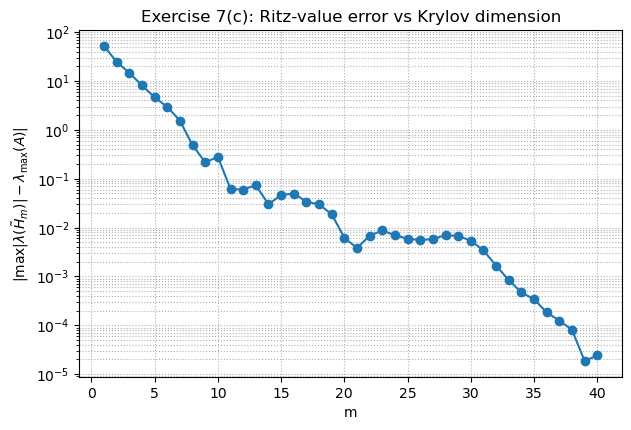

lambda_max(A) = 110.0
final error (m=40) = 2.413016864011297e-05


In [5]:
m_max = 40
u0 = rng.standard_normal(A_demo.shape[0])

Q, H = arnoldi(A_demo, u0, m=m_max)

lam_true = float(np.max(np.diag(A_demo)))

errs = []
ms = np.arange(1, m_max + 1)
for m in ms:
    Htilde = H[:m, :m]
    ritz = np.linalg.eigvals(Htilde)
    lam_hat = float(np.max(np.abs(ritz)))
    errs.append(abs(lam_hat - lam_true))

plt.figure(figsize=(7, 4.5))
plt.semilogy(ms, errs, marker='o')
plt.grid(True, which='both', ls=':')
plt.xlabel('m')
plt.ylabel(r'$|\max|\lambda(\tilde H_m)| - \lambda_{\max}(A)|$')
plt.title('Exercise 7(c): Ritz-value error vs Krylov dimension')
plt.show()

print('lambda_max(A) =', lam_true)
print('final error (m=40) =', errs[-1])
